In [1]:
%matplotlib inline
import itertools
import logging
import os
import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import AllKNN, NearMiss
from ray.tune.sklearn import TuneGridSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE, RFECV, SelectKBest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 400
sns.set()
GET_FROM_PICKLE = True
DATA_FILE = "./data.csv"
PICKLE_FILE = 'bankruptcy.pl'

logger = logging.getLogger("ray.tune")
logger.setLevel("CRITICAL")

In [2]:
if os.path.isfile(PICKLE_FILE) and GET_FROM_PICKLE:
    with open(PICKLE_FILE, 'rb') as f:
        data = pickle.load(f)
else:
    data = pd.read_csv(DATA_FILE)
    data.columns = data.columns.str.strip()
    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(data, f)

# Επισκόπηση Dataset

Το συγκεκριμένο dataset αποτελεί ένα σύνολο στοιχείων εταιρειών από το Taiwan Economic Journal για τα έτη 1999- 2009 και το γενικό πρόβλημα αποτελεί την πρόβλεψη της χρεοκοπίας ή οχι αυτών των εταιρειών.

Η μόνη μετατροπή που κάναμε στο αρχείο είναι πως επειδή μετά την εισαγωγή τα columns είχαν έναν χαρακτήρα κενού (' ') στην αρχή, έπρεπε να τον αφαιρέσουμε. Επίσης το dataset κατά την εισαγώγη του είχε έτοιμες τις επικεφαλίδες του αλλά δεν είχε αρίθμηση γραμμών.

In [3]:
data.shape

(6819, 96)

In [4]:
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [6]:
data.columns[data.isna().any()].tolist()

[]

Παρατηρούμε οτι δεν υπάρχουν απουσιάζουσες τιμές στο dataset μας.

In [7]:
features = data[data.columns.drop('Bankrupt?')]
labels = data['Bankrupt?'].astype('category')

In [8]:
features.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672

Συνολικά υπάρχουν 6819 δείγματα, στα οποία η  κάθε γραμμή αποτελεί μία ξεχωριστή εταιρεία, τα δεδομένα της οποίας συλλέχθηκαν από το Ταιβανέζικο χρηματιστήριο. Η πρώτη στήλη περιέχει το αν η εταιρεία έχει χρεοκοπήσει, και οι υπόλοιπες 95 χρηματιστηριακές μετρικές για αυτές (κάθε στήλη περιγράφεται αναλυτικά στο dataset από το αντίστοιχο label της). Μπορούμε να παρατηρήσουμε οτι όλα features είναι δοσμένα ως αριθμοί, 3 int64 εκ' των οποίων το ένα είναι το label "Bankrupt?". Μελετώντας το dataframe παρατηρούμε πως τα 3 int64 features αποτελούν διατεταγμένα χαρακτηριστικά, ενώ τα υπόλοιπα όχι.

In [9]:
print('Unique labels', np.unique(labels))
labels.value_counts(normalize=True)

Unique labels [0 1]


0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

Οι ετικέτες βρίσκονται στην κόλονα "Bankrupt?" και λαμβάνουν τις τιμές 1, 0, όπου 1 σημαίνει οτι η εταιρεία έχει πτωχεύσει και 0 οτι δεν πτώχευσε.

Παρατηρούμε επίσης πως το 96.8% του dataset είναι εταιρίες που δεν έχουν πτωχεύσει ενώ το 3.2% είναι εταιρείες που πτώχευσαν. Άρα το data set μας δεν είναι καθόλου ισορροπημένο και χρειάζεται διόρθωση.

In [10]:
print('Unique labels', np.unique(features['Liability-Assets Flag']))
features['Liability-Assets Flag'].value_counts(normalize=True)

Unique labels [0 1]


0    0.998827
1    0.001173
Name: Liability-Assets Flag, dtype: float64

In [11]:
print('Unique labels', np.unique(features['Net Income Flag']))
features['Net Income Flag'].value_counts(normalize=True)

Unique labels [1]


1    1.0
Name: Net Income Flag, dtype: float64

In [12]:
features['Liability-Assets Flag'] = features['Liability-Assets Flag'].astype(
    'category')
features['Net Income Flag'] = features['Net Income Flag'].astype('category')

In [13]:
categorical = ['Liability-Assets Flag', 'Net Income Flag']
numerical = list(features.drop(categorical, axis=1).columns)

Με βάση τα παραπάνω διαγράμματα παρατηρούμε πως τα features έχουν πολλά outliers και πως εχουν διαφορετικές μονάδες μέτρησης και δεν είναι ούτε κανονικοποιημένα ούτε σε μια συγκεκριμένη κλίμακα.

## Μετρικές

Επειδή το dataset μας είναι imbalanced θα αποφύγουμε να χρησιμοποιήσουμε την accuracy καθώς πρέπει να χρησιμοποιείται για balanced datasets. Επίσης επειδή θέλουμε να (...) χρησιμοποιούμε την μετρική recall και την μετρική f1-micro .Στην επιλογή των μετρικών μας βοήθησαν τα άρθρα: [Metrics To Evaluate Machine Learning Algorithms in Python](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/) και αυτό [Multi-Class Metrics Made Simple, Part I: Precision and Recall
](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)

In [14]:
scoring_metrics = [{
    'name':
        "F1-micro",
    'func': (
        lambda test_labels, preds: f1_score(test_labels, preds, average="micro")
    )
}, {
    'name': "Recall",
    'func': (lambda test_labels, preds: recall_score(test_labels, preds))
}]

## Train-test split και σχήμα CV

In [15]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.2)

ΠΟΥ ΤΟ ΞΕΡΕΙΣ ΕΙΜΑΙ ΕΓΚΩ ?????

## Επίδοση out-of-the-box

### Βοηθητικές συναρτήσεις

In [16]:
out_of_the_box_scores = pd.DataFrame()


def add_scores(metric, classifier, score):
    global out_of_the_box_scores
    out_of_the_box_scores = out_of_the_box_scores.append(
        {
            'Metric': metric,
            'Classifier': classifier,
            'Score': score
        },
        ignore_index=True)

### Dummy Classifier

In [17]:
dc = DummyClassifier()
dc.fit(train, train_labels)
preds = dc.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Dummy', metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.97      0.95      1364



### Multi-Layer Perceptron (MLP)

In [18]:
mlp = MLPClassifier()
mlp.fit(train, train_labels)
preds = mlp.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Multi-layer Perceptron',
               metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1318
           1       0.20      0.09      0.12        46

    accuracy                           0.96      1364
   macro avg       0.58      0.54      0.55      1364
weighted avg       0.94      0.96      0.95      1364



### Support Vector Machines (SVM)

In [19]:
svm = SVC()
svm.fit(train, train_labels)
preds = svm.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Support Vector Machine',
               metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.97      0.95      1364



### Παρουσίαση επίδοσης out-of-the-box

In [20]:
out_of_the_box_scores.groupby('Classifier').apply(
    lambda a: a.drop('Classifier', axis=1)[:])

Metric     Score
Classifier                                  
Dummy                  0  F1-micro  0.966276
                       1    Recall  0.000000
Multi-layer Perceptron 2  F1-micro  0.957478
                       3    Recall  0.086957
Support Vector Machine 4  F1-micro  0.966276
                       5    Recall  0.000000

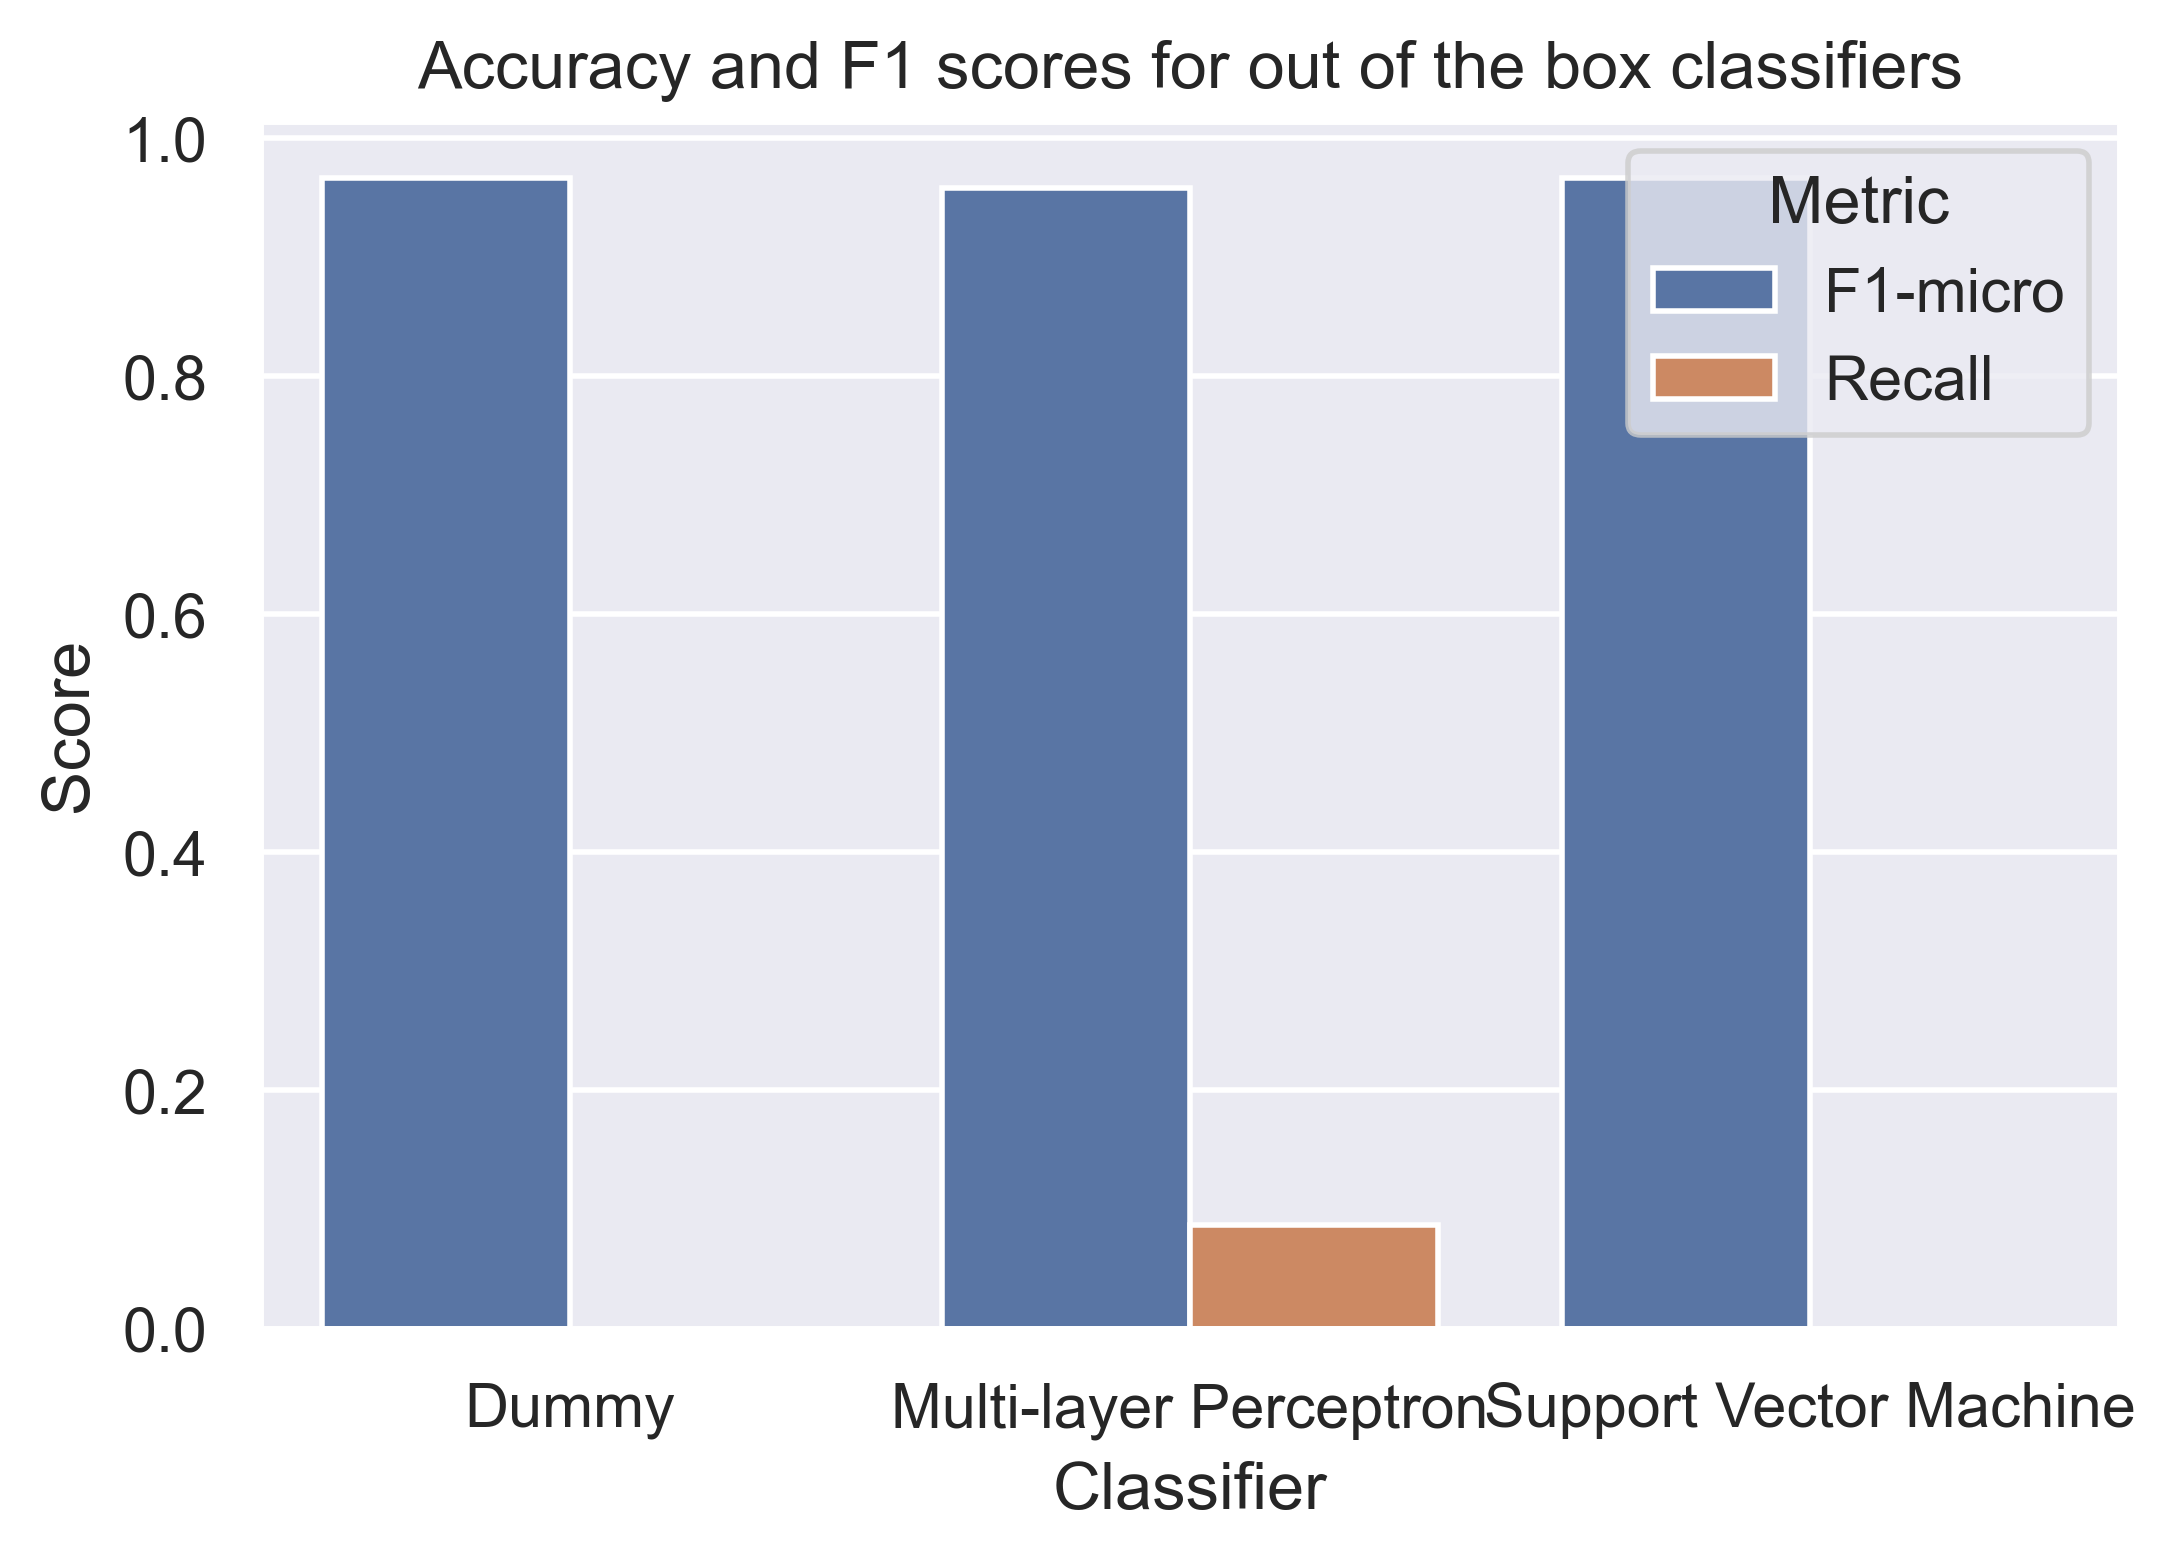

In [21]:
barplot = sns.barplot(data=out_of_the_box_scores,
                      y='Score',
                      x='Classifier',
                      hue='Metric')
barplot.set(title='Accuracy and F1 scores for out of the box classifiers')
plt.show()

## Βελτιστοποίηση

### Εισαγωγικά

Αρχικά παρατηρήσαμε οτι το column "Net Income Flag" δεν μας προσφέρει τίποτα αφού αποτελείται μόνο απο την τιμή 1. Άρα το κάνουμε drop:

In [22]:
features = features.drop(['Net Income Flag'], axis=1)

train_labels = train_labels.astype(float)

Επίσης πρέπει αναγκαστικά να ισορροπήσουμε το dataframe.

In [23]:
over_sampling = [('smote', SMOTE(0.3)), ('adasyn', ADASYN(0.3))]

under_sampling = [('near_miss', NearMiss()), ('all_knn', AllKNN())]

combine_sampling = [
    [('combine_sampler', i)] for i in [SMOTEENN(), SMOTETomek()]
]

# sampling = []
sampling = [list(i) for i in itertools.product(over_sampling, under_sampling)]
sampling.extend(combine_sampling)

Επίσης πρέπει να κάνουμε και scale τα δεδομένα μας

In [24]:
scaling = [[('robust_scaler', RobustScaler())],
           [('quantile_transformer', QuantileTransformer())]]

Λόγω των πολλών features πρέπει να τα μειώσουμε

In [25]:
feature_selection = [[('kbest', SelectKBest())],
                     [('rfe', RFE(estimator=DecisionTreeClassifier()))]]

In [26]:
other = [('pca', PCA())]

Δημιουργούμαι τα pipelines

In [27]:
operations = [
    i for i in itertools.product(sampling, scaling, feature_selection)
]

In [28]:
for i in range(len(operations)):
    extended_list = []
    for a in operations[i]:
        extended_list.extend(a)
    extended_list.extend(other)
    operations[i] = extended_list

In [29]:
len(operations)

24

In [30]:
for i, p in enumerate(operations):
    print(i, p)

0 [('smote', SMOTE(sampling_strategy=0.3)), ('near_miss', NearMiss()), ('robust_scaler', RobustScaler()), ('kbest', SelectKBest()), ('pca', PCA())]
1 [('smote', SMOTE(sampling_strategy=0.3)), ('near_miss', NearMiss()), ('robust_scaler', RobustScaler()), ('rfe', RFE(estimator=DecisionTreeClassifier())), ('pca', PCA())]
2 [('smote', SMOTE(sampling_strategy=0.3)), ('near_miss', NearMiss()), ('quantile_transformer', QuantileTransformer()), ('kbest', SelectKBest()), ('pca', PCA())]
3 [('smote', SMOTE(sampling_strategy=0.3)), ('near_miss', NearMiss()), ('quantile_transformer', QuantileTransformer()), ('rfe', RFE(estimator=DecisionTreeClassifier())), ('pca', PCA())]
4 [('smote', SMOTE(sampling_strategy=0.3)), ('all_knn', AllKNN()), ('robust_scaler', RobustScaler()), ('kbest', SelectKBest()), ('pca', PCA())]
5 [('smote', SMOTE(sampling_strategy=0.3)), ('all_knn', AllKNN()), ('robust_scaler', RobustScaler()), ('rfe', RFE(estimator=DecisionTreeClassifier())), ('pca', PCA())]
6 [('smote', SMOTE(s

In [31]:
params = {
    'smote': {},
    'adasyn': {},
    'near_miss': {},
    'all_knn': {},
    'combine_sampler': {},
    'robust_scaler': {
        'with_centering': [True, False],
        'with_scaling': [True, False],
        'unit_variance': [True, False],
    },
    'quantile_transformer': {
        'n_quantiles': []
    },
    'kbest': {
        'k': [*[i for i in range(20, 10, 100)], 'all']
    },
    'rfe': {
        'n_features_to_select': [i / 10 for i in range(1, 11)]
    },
    'pca': {
        'n_components': [i / 10 for i in range(5, 11)]
    },
    'dummy': {
        'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
    },
    'mlp': {
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.00001, 0.0001, 0.001],
        'solver': ['adam', 'lbfgs']
    },
    'svc': {
        'gamma': [0.001, 0.1, 1],
        'C': [0.1, 1, 10]
    }
}


def get_params(operations):
    print(operations)
    params_dict = {}
    for (op_name, _) in operations:
        if op_name in params:
            for k, v in params[op_name].items():
                params_dict[op_name + '__' + k] = v
    return params_dict

In [32]:
preprocessing_scores = pd.DataFrame()

# def train_best_model(cv_classifier, classifier, scoring_metric):
#     global preprocessing_scores
#     pipe = cv_classifier.best_estimator_

#     start_time = time.time()
#     pipe.fit(train, train_labels)
#     train_time = time.time() - start_time

#     start_time = time.time()
#     preds = pipe.predict(test)
#     test_time = time.time() - start_time

#     score_f1 = f1_score(test_labels, preds)

#     preprocessing_scores = preprocessing_scores.append(
#         {
#             "Classifier": classifier,
#             "Scoring_metric": scoring_metric,
#             "F1": score_f1,
#             "ΔF1": score_f1 - out_of_the_box_scores('F1'),
#             "Train_time": train_time,
#             "Test_time": test_time,
#             "Preds": preds
#         },
#         ignore_index=True)


def use_grid_search(operations, scoring_metric, param_grid, classifier):
    pipe = Pipeline(steps=operations, memory='tmp')
    cv_classifier = TuneGridSearchCV(pipe,
                                     param_grid,
                                     cv=5,
                                     scoring=scoring_metric)

    cv_classifier.fit(train, train_labels)

    print('''Statistics for {} on {} scoring metric:
          Best Score = {}
          Best Estimator = {}'''.format(classifier, scoring_metric,
                                        cv_classifier.best_score_,
                                        cv_classifier.best_estimator_))
    return cv_classifier

### Dummy Classifier

In [33]:
classifier = [('dummy', DummyClassifier())]
for metric in scoring_metrics:
    scores = []
    estimators = []

    for op in operations:
        new_op = op + classifier
        use_grid_search(new_op, 'f1', get_params(new_op), 'Dummy')
        break

[('smote', SMOTE(sampling_strategy=0.3)), ('near_miss', NearMiss()), ('robust_scaler', RobustScaler()), ('kbest', SelectKBest()), ('pca', PCA()), ('dummy', DummyClassifier())]


RayTaskError(ValueError): [36mray::_Trainable.train_buffered()[39m (pid=77404, ip=127.0.0.1, repr=<tune_sklearn._trainable._Trainable object at 0x0000020F26DEE808>)
  File "python\ray\_raylet.pyx", line 565, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 569, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 519, in ray._raylet.execute_task.function_executor
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\_private\function_manager.py", line 576, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
    return method(self, *_args, **_kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\tune\trainable.py", line 224, in train_buffered
    result = self.train()
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
    return method(self, *_args, **_kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\tune\trainable.py", line 283, in train
    result = self.step()
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
    return method(self, *_args, **_kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\tune_sklearn\_trainable.py", line 106, in step
    return self._train()
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
    return method(self, *_args, **_kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\tune_sklearn\_trainable.py", line 247, in _train
    error_score="raise")
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\model_selection\_validation.py", line 283, in cross_validate
    for train, test in cv.split(X, y, groups)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\parallel.py", line 263, in __call__
    for func, args, kwargs in self.items]
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\parallel.py", line 263, in <listcomp>
    for func, args, kwargs in self.items]
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\utils\fixes.py", line 211, in __call__
    return self.function(*args, **kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    **fit_params_steps[name],
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\memory.py", line 594, in __call__
    return self._cached_call(args, kwargs)[0]
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\memory.py", line 537, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\joblib\memory.py", line 779, in call
    output = self.func(*args, **kwargs)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\imblearn\pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\imblearn\base.py", line 77, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\imblearn\base.py", line 132, in _check_X_y
    X, y = self._validate_data(X, y, reset=True, accept_sparse=accept_sparse)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\base.py", line 576, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\utils\validation.py", line 968, in check_X_y
    estimator=estimator,
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\utils\validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "D:\Users\keras\miniforge3\envs\ray\lib\site-packages\sklearn\utils\validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
clf = DummyClassifier()

for method in metrics:
    scores = []
    estimators = []

    for i in range(len(steps)):
        # Construct the pipe with the specific architecture for this classifier
        mySteps = steps[i][:]
        mySteps.append(('dummy', clf))
        pipe = Pipeline(steps=mySteps, memory='tmp')

        # Construct a temporary dictionary with only the values needed for this pipe
        myDictionary = {
            'dummy__strategy': [
                'stratified', 'most_frequent', 'prior', 'uniform', 'constant'
            ]
        }
        for element in mySteps:
            name = element[0]
            if name == 'selector':
                myDictionary['selector__threshold'] = vthreshold
            elif name == 'pca':
                myDictionary['pca__n_components'] = n_components
            elif name == 'std_scaler':
                myDictionary['std_scaler__with_mean'] = tf
                myDictionary['std_scaler__with_std'] = tf

        estimator = GridSearchCV(pipe,
                                 myDictionary,
                                 cv=10,
                                 scoring=method,
                                 n_jobs=-1)

        # Find the optimal model for this pipeline architecture
        estimator.fit(train, train_labels)

        scores.append(estimator.best_score_)
        estimators.append(estimator.best_estimator_)

    max_score = max(scores)
    max_index = scores.index(max_score)
    max_estimator = estimators[max_index]

    myBestEstimators.append(max_estimator)

    print('Optimal estimator for metric {} is:\n{}'.format(
        method, max_estimator))
    print('with score: {:.2f} %'.format(max_score * 100))

## Τεκμηρίωση της διαδικασίας

## Παρουσίαση αποτελεσμάτων

## Συμπεράσματα